#  Классификация изображений с помощью сверточных нейронных сетей


In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn import metrics
import seaborn as sns
import pandas as pd

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [2]:
def calculate_accuracy(predictions, grs):
    """Multiclass problem accuracy"""
    predictions = torch.softmax(predictions, dim=1)
    predictions = torch.argmax(predictions, dim=1)
    return (torch.sum(predictions == grs) / len(grs)).item()

In [3]:
def classification_loop(train_loader, test_loader, model, criterion, optimizer, epochs, device="cuda"):
    """Training loop for c-class classification problem"""
    train_loss_history = []
    test_loss_history = []

    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        train_acc = 0.0
        test_loss = 0.0
        test_acc = 0.0
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += calculate_accuracy(predictions, y_batch)
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_loss_history.append(train_loss)

        with torch.inference_mode():
            model.eval()
            for x_test_batch, y_test_batch in test_loader:
                x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)
                test_predictions = model(x_test_batch)
                test_loss += criterion(test_predictions, y_test_batch).item()
                test_acc += calculate_accuracy(test_predictions, y_test_batch)
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
        test_loss_history.append(test_loss)
        print(f"Epoch: {epoch} | Train loss: {train_loss} | Train acc: {train_acc} | Test loss: {test_loss} |\
Test acc: {test_acc}")
    return train_loss_history, test_loss_history

Создаем датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`.
Датасет состоит из 4000 фотографий, которые делятся на 4 класса `American Shorthair, Persian, Russian Blue, Tiger`

In [5]:
import zipfile
import os
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/datasets/cat_breeds_4.zip'
extract_path = '/content/data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in tqdm(zip_ref.infolist(), desc="Extracting"):
        zip_ref.extract(member, extract_path)

print("Extraction completed!")


ModuleNotFoundError: No module named 'google.colab'

In [4]:
import zipfile
import os
from tqdm import tqdm
zip_path = '/home/jupyter/datasphere/project/cat_breeds_4.zip'
extract_path = '/home/jupyter/datasphere/project/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in tqdm(zip_ref.infolist(), desc="Extracting"):
        zip_ref.extract(member, extract_path)

print("Extraction completed!")


Extracting: 100%|██████████| 4005/4005 [00:08<00:00, 473.97it/s]

Extraction completed!


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Определите трансформации, которые будут применены к изображениям
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Измените размер изображения, если нужно
    transforms.ToTensor()           # Преобразует изображение в тензор
])

# Укажите путь к датасету и создайте объект ImageFolder
dataset_path = r"C:\Users\arsen\Desktop\cat_breeds_4"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Создайте DataLoader для загрузки данных
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Вывод классов для проверки
print("Classes:", dataset.classes)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\arsen\\Desktop\\cat_breeds_4'

In [5]:
dataset_folder = os.path.join(extract_path, 'cat_breeds_4')
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=dataset_folder, transform=transform)

In [6]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count
    return mean, std

mean, std = calculate_mean_std(dataset)

In [7]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = datasets.ImageFolder(root=dataset_folder, transform=transform)

In [8]:
image_size = dataset[0][0].size()
num_classes = len(dataset.classes)
num_images = len(dataset)
print(f'количество фото: {num_images}, размер одной картинки: {image_size}, классы: {dataset.classes}')

количество фото: 4000, размер одной картинки: torch.Size([3, 512, 512]), классы: ['American Shorthair', 'Persian', 'Russian Blue', 'Tiger']


In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

Решаем задачу классификации пока что не используя сверточные слои.

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [46]:
class CatbreedModel(nn.Module):
    def __init__(self):
        super(CatbreedModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 512 * 3, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256,128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128,64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 4)

        self.dropout = nn.Dropout(0.4)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CatbreedModel().to(device)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [49]:
train_loss_history, test_loss_history = classification_loop(
    train_loader, test_loader, model, criterion, optimizer, 10
)

 10%|█         | 1/10 [00:32<04:55, 32.80s/it]

Epoch: 0 | Train loss: 1.365379295349121 | Train acc: 0.318125 | Test loss: 1.3226832976708045 |Test acc: 0.3713942307692308


 20%|██        | 2/10 [01:05<04:21, 32.74s/it]

Epoch: 1 | Train loss: 1.312960376739502 | Train acc: 0.3784375 | Test loss: 1.298520381634052 |Test acc: 0.39783653846153844


 30%|███       | 3/10 [01:38<03:48, 32.69s/it]

Epoch: 2 | Train loss: 1.289561734199524 | Train acc: 0.40625 | Test loss: 1.3076407175797682 |Test acc: 0.3641826923076923


 40%|████      | 4/10 [02:10<03:16, 32.74s/it]

Epoch: 3 | Train loss: 1.2700170350074769 | Train acc: 0.416875 | Test loss: 1.2843317527037401 |Test acc: 0.38341346153846156


 50%|█████     | 5/10 [02:43<02:43, 32.75s/it]

Epoch: 4 | Train loss: 1.2438713812828064 | Train acc: 0.446875 | Test loss: 1.2810619611006517 |Test acc: 0.40024038461538464


 60%|██████    | 6/10 [03:16<02:10, 32.73s/it]

Epoch: 5 | Train loss: 1.231776990890503 | Train acc: 0.453125 | Test loss: 1.283842948766855 |Test acc: 0.39783653846153844


 70%|███████   | 7/10 [03:49<01:38, 32.73s/it]

Epoch: 6 | Train loss: 1.2201248979568482 | Train acc: 0.46875 | Test loss: 1.2786641304309552 |Test acc: 0.4074519230769231


 80%|████████  | 8/10 [04:21<01:05, 32.70s/it]

Epoch: 7 | Train loss: 1.2033701205253602 | Train acc: 0.5034375 | Test loss: 1.2645659079918494 |Test acc: 0.4110576923076923


 90%|█████████ | 9/10 [04:54<00:32, 32.75s/it]

Epoch: 8 | Train loss: 1.185549397468567 | Train acc: 0.51125 | Test loss: 1.2661744631253755 |Test acc: 0.41346153846153844
Epoch: 9 | Train loss: 1.171506836414337 | Train acc: 0.5190625 | Test loss: 1.2653660774230957 |Test acc: 0.40625


100%|██████████| 10/10 [05:27<00:00, 32.75s/it]


##  предыдущие результаты

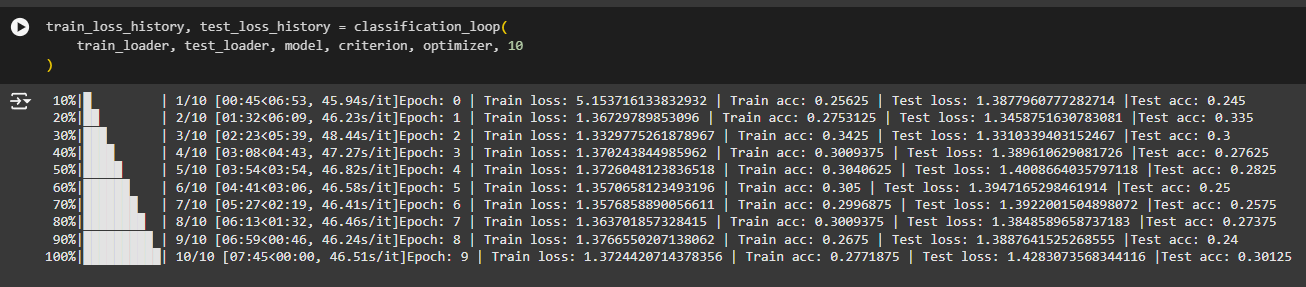

Точность не особо высокая, всего лишь 40 процентов на валидационном наборе данных, что доказывает бесполезность использования полносвязных слоев


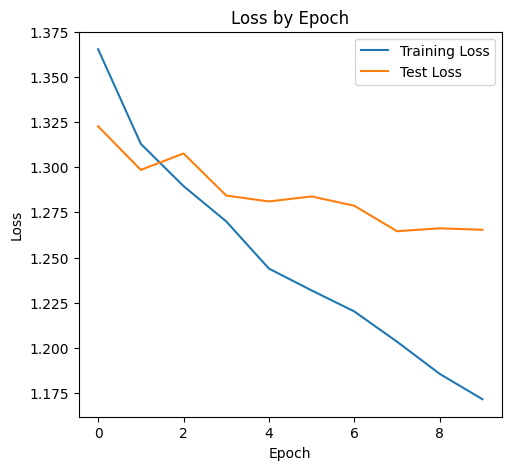

In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.legend()

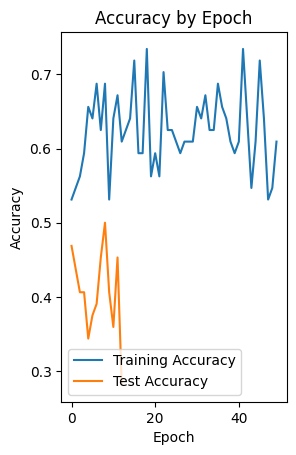

In [52]:
import warnings
warnings.filterwarnings('ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"
train_acc_history = [calculate_accuracy(torch.tensor(model(x_batch.to(device)).detach().cpu()), y_batch)
                     for x_batch, y_batch in train_loader]
test_acc_history = [calculate_accuracy(torch.tensor(model(x_batch.to(device)).detach().cpu()), y_batch)
                    for x_batch, y_batch in test_loader]

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


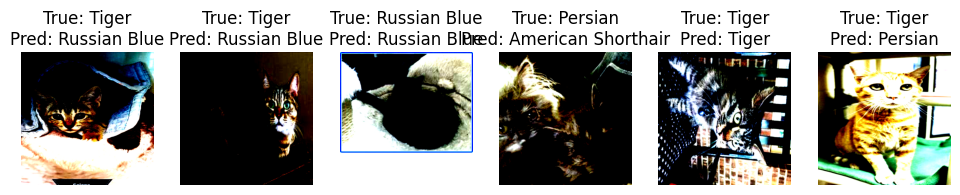

In [57]:
import numpy as np
classes = dataset.classes
num_images = 6
indices = np.random.choice(len(dataset), num_images, replace=False)

plt.figure(figsize=(12, 4))
for i, idx in enumerate(indices):
    img, label = dataset[idx]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img).argmax().item()
    img = img.cpu().squeeze(0)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img.reshape(3, 512, 512).permute(1, 2, 0))
    plt.title(f"True: {classes[label]}\nPred: {classes[pred]}")
    plt.axis('off')
plt.show()

Задача классификации используя сверточные слои. 

In [10]:
class  CNNCatbreedModel(nn.Module):
    def __init__(self):
        super(CNNCatbreedModel, self).__init__()
        
        # Сверточные блоки с батч-нормализацией и пуллингом
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Полносвязные слои с дропаутом
        self.fc1 = nn.Linear(256 * 64 * 64, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn7 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 4)
        
        self.dropout = nn.Dropout(0.4)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Проход через сверточные блоки
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        
        # Разворачиваем для полносвязных слоев
        x = x.view(-1, 256 * 64 * 64)
        
        # Полносвязные слои с батч-нормализацией, дропаутом и активацией
        x = self.dropout(self.relu(self.bn4(self.fc1(x))))
        x = self.relu(self.bn5(self.fc2(x)))
        x = self.relu(self.bn6(self.fc3(x)))
        x = self.relu(self.bn7(self.fc4(x)))
        
        # Последний полносвязный слой для классификации
        x = self.fc5(x)
        return x


In [11]:
import torch
from tqdm import tqdm

def classification_loop(train_loader, test_loader, model, criterion, optimizer, epochs, device="cuda"):
    """Training loop for c-class classification problem with optimized CUDA memory management."""
    train_loss_history = []
    test_loss_history = []

    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        train_acc = 0.0
        test_loss = 0.0
        test_acc = 0.0

        # Training phase
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(x_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            
            # Accumulate losses and accuracy
            train_loss += loss.item()
            train_acc += calculate_accuracy(predictions, y_batch)

            # Delete unnecessary variables and clear cache after each batch
            del x_batch, y_batch, predictions, loss
            torch.cuda.empty_cache()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_loss_history.append(train_loss)

        # Evaluation phase (test)
        with torch.inference_mode():
            model.eval()
            for x_test_batch, y_test_batch in test_loader:
                x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)
                test_predictions = model(x_test_batch)
                test_loss += criterion(test_predictions, y_test_batch).item()
                test_acc += calculate_accuracy(test_predictions, y_test_batch)

                # Delete unnecessary variables and clear cache after each batch
                del x_test_batch, y_test_batch, test_predictions
                torch.cuda.empty_cache()

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
        test_loss_history.append(test_loss)

        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | "
              f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    return train_loss_history, test_loss_history


In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
torch.cuda.empty_cache()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNCatbreedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
train_loss_history, test_loss_history = classification_loop(
    train_loader, test_loader, model, criterion, optimizer, 10
)

 10%|█         | 1/10 [01:13<11:05, 73.92s/it]

Epoch: 1 | Train loss: 1.3369 | Train acc: 0.3566 | Test loss: 1.2990 | Test acc: 0.3850


 20%|██        | 2/10 [02:23<09:32, 71.59s/it]

Epoch: 2 | Train loss: 1.2020 | Train acc: 0.4606 | Test loss: 1.2654 | Test acc: 0.4113


 30%|███       | 3/10 [03:34<08:17, 71.14s/it]

Epoch: 3 | Train loss: 1.1169 | Train acc: 0.5244 | Test loss: 1.1868 | Test acc: 0.4925


 40%|████      | 4/10 [04:45<07:05, 70.96s/it]

Epoch: 4 | Train loss: 1.0123 | Train acc: 0.5722 | Test loss: 1.1517 | Test acc: 0.5238


 50%|█████     | 5/10 [05:55<05:54, 70.82s/it]

Epoch: 5 | Train loss: 0.8700 | Train acc: 0.6628 | Test loss: 1.2103 | Test acc: 0.4975


 60%|██████    | 6/10 [07:06<04:42, 70.70s/it]

Epoch: 6 | Train loss: 0.7376 | Train acc: 0.7231 | Test loss: 1.2324 | Test acc: 0.5275


 70%|███████   | 7/10 [08:17<03:32, 70.78s/it]

Epoch: 7 | Train loss: 0.5760 | Train acc: 0.7881 | Test loss: 1.3901 | Test acc: 0.5238


 80%|████████  | 8/10 [09:27<02:21, 70.60s/it]

Epoch: 8 | Train loss: 0.4666 | Train acc: 0.8341 | Test loss: 1.4553 | Test acc: 0.4888


 90%|█████████ | 9/10 [10:37<01:10, 70.41s/it]

Epoch: 9 | Train loss: 0.3759 | Train acc: 0.8688 | Test loss: 1.4375 | Test acc: 0.5250


100%|██████████| 10/10 [11:48<00:00, 70.82s/it]

Epoch: 10 | Train loss: 0.2654 | Train acc: 0.9122 | Test loss: 1.5874 | Test acc: 0.4900


In [1]:
Точность на обучающем 90%, а на валидационном всего лишь 49%, это указывает на переобучение модели

SyntaxError: invalid syntax (26837821.py, line 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


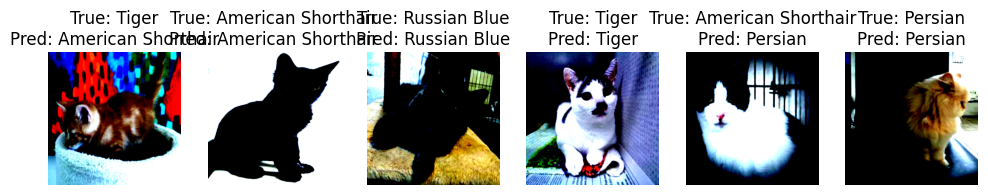

In [16]:
import numpy as np
classes = dataset.classes
num_images = 6
indices = np.random.choice(len(dataset), num_images, replace=False)

plt.figure(figsize=(12, 4))
for i, idx in enumerate(indices):
    img, label = dataset[idx]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img).argmax().item()
    img = img.cpu().squeeze(0)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img.reshape(3, 512, 512).permute(1, 2, 0))
    plt.title(f"True: {classes[label]}\nPred: {classes[pred]}")
    plt.axis('off')
plt.show()

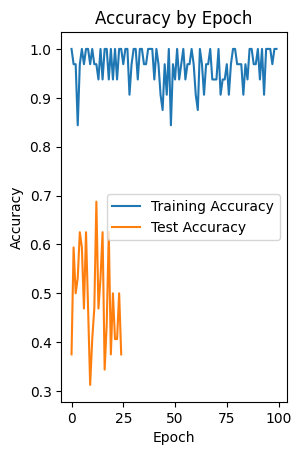

In [17]:
import warnings
warnings.filterwarnings('ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"
train_acc_history = [calculate_accuracy(torch.tensor(model(x_batch.to(device)).detach().cpu()), y_batch)
                     for x_batch, y_batch in train_loader]
test_acc_history = [calculate_accuracy(torch.tensor(model(x_batch.to(device)).detach().cpu()), y_batch)
                    for x_batch, y_batch in test_loader]

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()

plt.show()

модель переобучена

# Улучшение модели

In [40]:
class CNNCatbreedModel(nn.Module):
    def __init__(self):
        super(CNNCatbreedModel, self).__init__()
        
        # Сверточные слои с батч нормализацией и пулингом
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Слой 1
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Слой 2
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Слой 3
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Слой 4
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)  # Слой 5
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)  # Слой 6
        self.bn6 = nn.BatchNorm2d(512)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)  # Слой 7
        self.bn7 = nn.BatchNorm2d(512)
        self.pool7 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Полносвязные слои
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.bn8 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn9 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,128)
        self.bn10 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn11 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 4)

        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))
        x = self.pool6(F.relu(self.bn6(self.conv6(x))))
        x = self.pool7(F.relu(self.bn7(self.conv7(x))))
        
        x = self.flatten(x)
        x = self.dropout(F.relu(self.bn8(self.fc1(x))))
        x = F.relu(self.bn9(self.fc2(x)))
        x = self.dropout(F.relu(self.bn10(self.fc3(x))))
        x = F.relu(self.bn11(self.fc4(x)))
        x = self.fc5(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNCatbreedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [41]:
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

In [42]:
dataset = datasets.ImageFolder(root=dataset_folder, transform=data_transforms)

In [43]:
image_size = dataset[0][0].size()
num_classes = len(dataset.classes)
num_images = len(dataset)
print(f'количество фото: {num_images}, размер одной картинки: {image_size}, классы: {dataset.classes}')

количество фото: 4000, размер одной картинки: torch.Size([3, 512, 512]), классы: ['American Shorthair', 'Persian', 'Russian Blue', 'Tiger']


In [44]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [45]:
train_loss_history, test_loss_history = classification_loop(
    train_loader, test_loader, model, criterion, optimizer, epochs=20
)

  5%|▌         | 1/20 [02:00<38:10, 120.53s/it]

Epoch: 1 | Train loss: 1.3352 | Train acc: 0.3547 | Test loss: 1.2413 | Test acc: 0.4713


 10%|█         | 2/20 [03:55<35:08, 117.17s/it]

Epoch: 2 | Train loss: 1.2243 | Train acc: 0.4691 | Test loss: 1.1794 | Test acc: 0.4900


 15%|█▌        | 3/20 [05:48<32:43, 115.53s/it]

Epoch: 3 | Train loss: 1.1873 | Train acc: 0.4831 | Test loss: 1.1077 | Test acc: 0.5375


 20%|██        | 4/20 [07:43<30:42, 115.13s/it]

Epoch: 4 | Train loss: 1.1378 | Train acc: 0.5178 | Test loss: 1.0995 | Test acc: 0.5288


 25%|██▌       | 5/20 [09:37<28:39, 114.65s/it]

Epoch: 5 | Train loss: 1.1064 | Train acc: 0.5281 | Test loss: 1.0711 | Test acc: 0.5563


 30%|███       | 6/20 [11:31<26:43, 114.54s/it]

Epoch: 6 | Train loss: 1.0821 | Train acc: 0.5463 | Test loss: 1.0359 | Test acc: 0.5800


 35%|███▌      | 7/20 [13:25<24:47, 114.39s/it]

Epoch: 7 | Train loss: 1.0621 | Train acc: 0.5663 | Test loss: 1.0579 | Test acc: 0.5637


 40%|████      | 8/20 [15:19<22:52, 114.37s/it]

Epoch: 8 | Train loss: 1.0288 | Train acc: 0.5803 | Test loss: 0.9914 | Test acc: 0.5925


 45%|████▌     | 9/20 [17:13<20:56, 114.23s/it]

Epoch: 9 | Train loss: 0.9974 | Train acc: 0.6006 | Test loss: 1.0082 | Test acc: 0.5837


 50%|█████     | 10/20 [19:07<19:01, 114.14s/it]

Epoch: 10 | Train loss: 0.9694 | Train acc: 0.6078 | Test loss: 1.0417 | Test acc: 0.5813


 55%|█████▌    | 11/20 [21:01<17:06, 114.01s/it]

Epoch: 11 | Train loss: 0.9398 | Train acc: 0.6288 | Test loss: 0.9313 | Test acc: 0.6275


 60%|██████    | 12/20 [22:55<15:11, 113.97s/it]

Epoch: 12 | Train loss: 0.9056 | Train acc: 0.6378 | Test loss: 0.9361 | Test acc: 0.6375


 65%|██████▌   | 13/20 [24:49<13:17, 113.94s/it]

Epoch: 13 | Train loss: 0.8905 | Train acc: 0.6353 | Test loss: 1.3302 | Test acc: 0.4950


 70%|███████   | 14/20 [26:43<11:24, 114.14s/it]

Epoch: 14 | Train loss: 0.8538 | Train acc: 0.6634 | Test loss: 1.0630 | Test acc: 0.5637


 75%|███████▌  | 15/20 [28:38<09:30, 114.18s/it]

Epoch: 15 | Train loss: 0.8391 | Train acc: 0.6625 | Test loss: 0.9283 | Test acc: 0.6275


 80%|████████  | 16/20 [30:36<07:41, 115.28s/it]

Epoch: 16 | Train loss: 0.8046 | Train acc: 0.6806 | Test loss: 0.8490 | Test acc: 0.6587


 85%|████████▌ | 17/20 [32:31<05:45, 115.24s/it]

Epoch: 17 | Train loss: 0.8039 | Train acc: 0.6844 | Test loss: 0.8973 | Test acc: 0.6338


 90%|█████████ | 18/20 [34:25<03:49, 114.91s/it]

Epoch: 18 | Train loss: 0.7574 | Train acc: 0.6953 | Test loss: 1.0337 | Test acc: 0.5988


 95%|█████████▌| 19/20 [36:19<01:54, 114.81s/it]

Epoch: 19 | Train loss: 0.7451 | Train acc: 0.7059 | Test loss: 0.9793 | Test acc: 0.6100


100%|██████████| 20/20 [38:13<00:00, 114.69s/it]

Epoch: 20 | Train loss: 0.7353 | Train acc: 0.7091 | Test loss: 0.8705 | Test acc: 0.6438


Результаты стали лучше.
Accuracy 64%

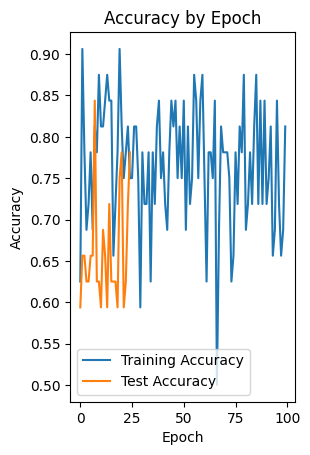

In [46]:
import warnings
warnings.filterwarnings('ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"
train_acc_history = [calculate_accuracy(torch.tensor(model(x_batch.to(device)).detach().cpu()), y_batch)
                     for x_batch, y_batch in train_loader]
test_acc_history = [calculate_accuracy(torch.tensor(model(x_batch.to(device)).detach().cpu()), y_batch)
                    for x_batch, y_batch in test_loader]

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()

plt.show()

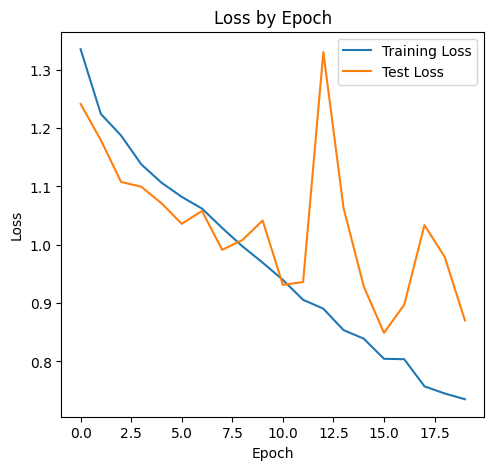

In [47]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.legend()

Анализ обученной модели, исследовав обученные ядра сверточных слоев.

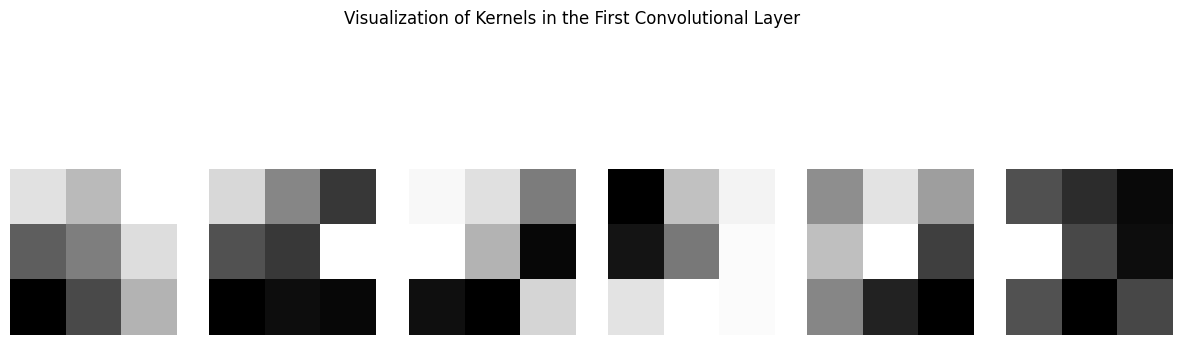

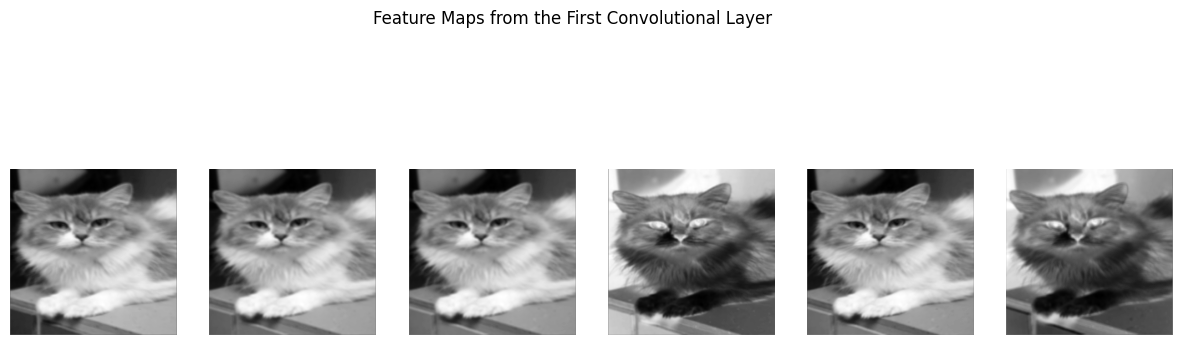

In [ ]:
sample_image, label = next(iter(test_loader))
sample_image = sample_image[0].unsqueeze(0)

model.eval()

with torch.no_grad():
    first_conv_layer = model.conv1(sample_image)

feature_maps = first_conv_layer.squeeze(0).cpu().numpy()

def visualize_kernels(layer, num_kernels=6):
    kernels = layer.weight.data.cpu().numpy()

    plt.figure(figsize=(15, 5))
    for i in range(num_kernels):
        plt.subplot(1, num_kernels, i + 1)
        plt.imshow(kernels[i, 0, :, :], cmap='gray')
        plt.axis('off')
    plt.suptitle("Visualization of Kernels in the First Convolutional Layer")
    plt.show()

def visualize_feature_maps(feature_maps, num_maps=6):
    plt.figure(figsize=(15, 5))
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(feature_maps[i], cmap='gray')
        plt.axis('off')
    plt.suptitle("Feature Maps from the First Convolutional Layer")
    plt.show()

visualize_kernels(model.conv1, num_kernels=6)
visualize_feature_maps(feature_maps, num_maps=6)